# AutoViz.jl Tutorial

AutoViz.jl is a package for rendering simple scenes mainly consisting of cars on roadways using Cairo. 

This tutorial provides examples of the main features of AutoViz like rendering roadways and vehicles, adding overlays containing extra information like text, making animations, and using different cameras.
It provides basic examples, for more advanced usage refer to the documentation or use `?` in the REPL to know about all the possible options of a given type or function.

To run this tutorial, you must be using julia 1.1+ and have [AutoViz.jl](https://github.com/sisl/AutoViz.jl) installed. Look at the README for installation instructions.

In [1]:
using AutoViz
AutoViz.colortheme["background"] = colorant"white"; # set the background color to white

┌ Info: Precompiling AutoViz [82aa6e0c-a491-5edf-8d4b-c16b98e4ea17]
└ @ Base loading.jl:1273


## Rendering basic driving senes

AutoViz.jl has been mostly designed to provide rendering support for [AutomotiveDrivingModels.jl](https://github.com/sisl/AutomotiveDrivingModels.jl).

It provides basic functionality to render objects from AutomotiveDrivingModels like roadways and scenes. 

Let's create a basic roadways with vehicle using AutomotiveDrivingModels and render it.

In [2]:
using AutomotiveDrivingModels

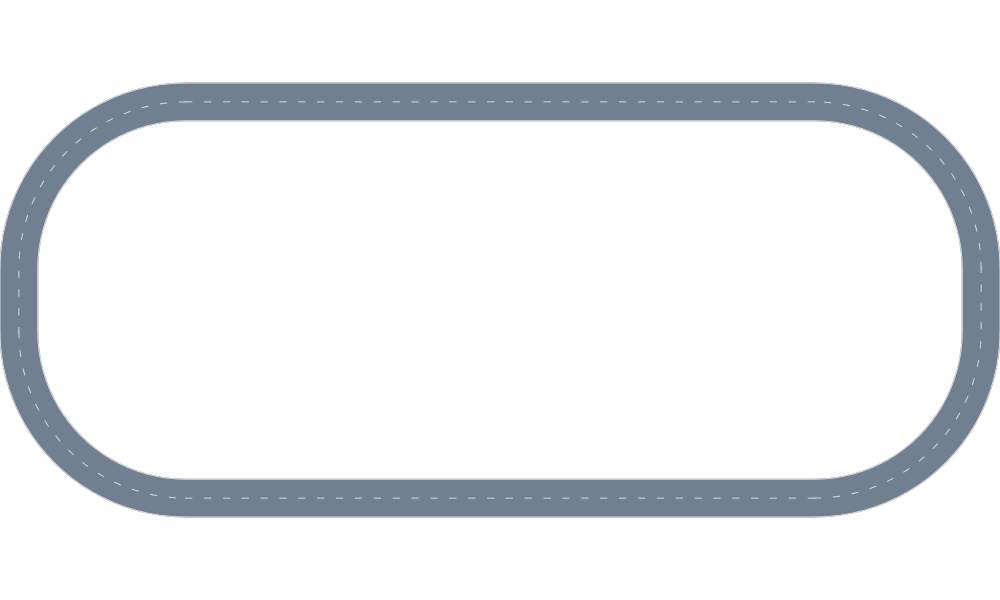

In [4]:
roadway = gen_stadium_roadway(2)
render([roadway], camera=FitToContentCamera(0.0))

The `Roadway` object can be directly passed to the `render` function in the list of renderable objects. 
The camera argument is used to center the camera and make the roadway fit in the canvas. See the camera section for more information.

Now let's add vehicles.

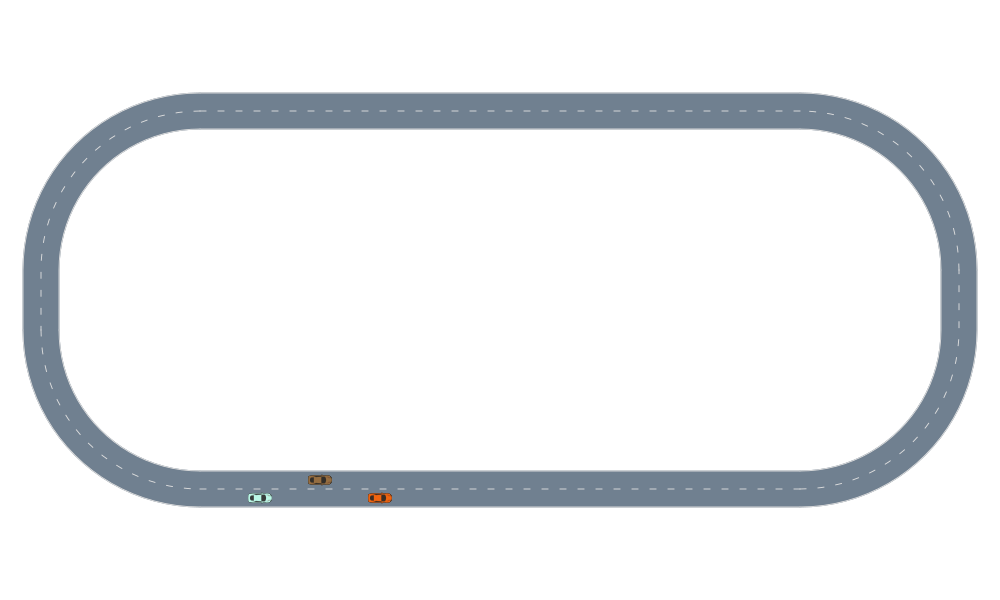

In [4]:
# see AutomotiveDrivingModels doc for creating vehicles
veh1 = Vehicle(VehicleState(VecSE2(10.0,-DEFAULT_LANE_WIDTH,0.0), roadway, 29.0+randn()), 
                    VehicleDef(), 1)
veh2 = Vehicle(VehicleState(VecSE2(20.0,0.0,0.0), roadway, 29.0+randn()), 
                    VehicleDef(), 2)
veh3 = Vehicle(VehicleState(VecSE2(30.0,-DEFAULT_LANE_WIDTH,0.0), roadway, 29.0+randn()), 
                    VehicleDef(), 3)

scene = Frame([veh1, veh2, veh3])

render([roadway, scene], camera=StaticCamera(position=(50,30), zoom=6.))

As the scene is passed after the roadway, the vehicle are rendered on top of the roadway. 

One can also render a single vehicle.

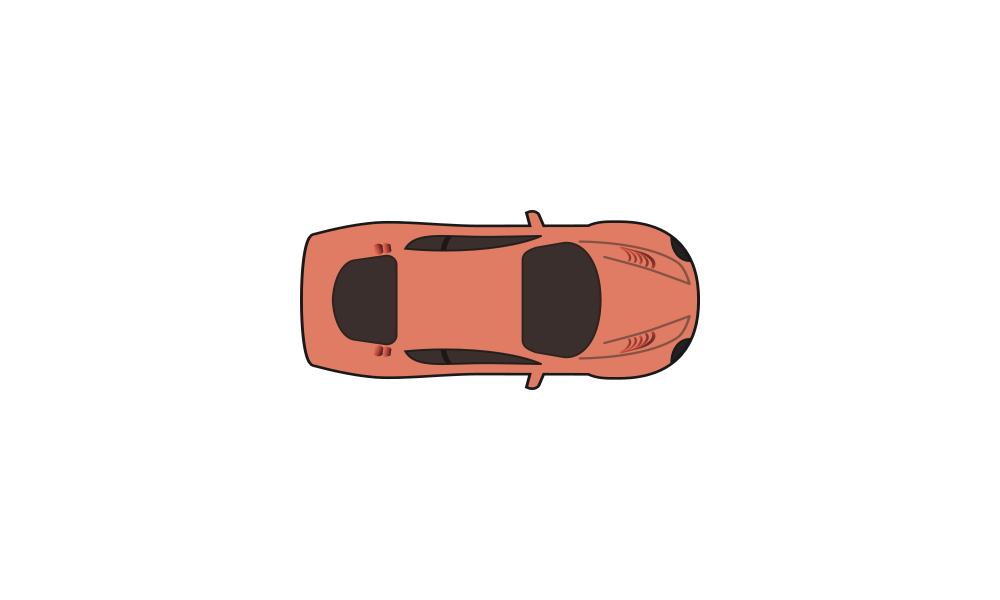

In [5]:
render([veh1], camera=StaticCamera(position=(10.,-3.),zoom=100.))

**Controlling the appearance of the vehicles**

By defautl, the vehicles are rendered in "fancy" mode and are assigned with a random color. 

To specify the appearance of a vehicle, you can use one of the following wrappers: `FancyCar` (default), `ArrowCar`, `EntityRectangle`.

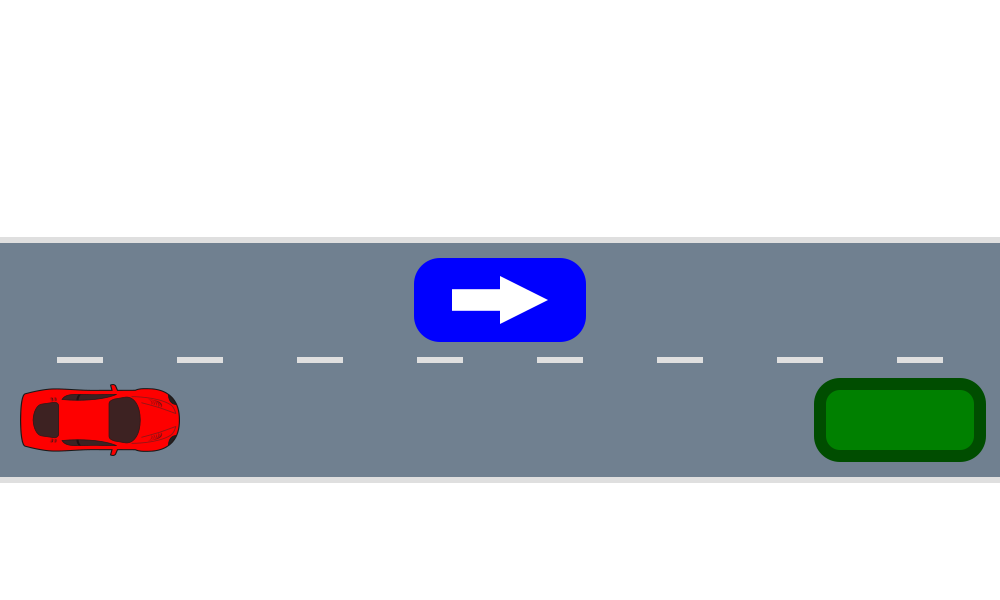

In [6]:
render([roadway, FancyCar(veh1, colorant"red"), ArrowCar(veh2, colorant"blue"), EntityRectangle(veh3, colorant"green")], 
        camera=StaticCamera(position=(20,0), zoom=40.))

## Cameras

Cameras are useful to modify the zoom or move the content on the canvas. AutoViz provide some useful camera types to create different focus effect: `StaticCamera` ,`TargetFollowCamera`, `SceneFollowCamera`.
The camera objects in AutoViz describe a camera behavior. 
This behavior takes effect when calling the function `update_camera!` prior to the `render` function.

You can also implement your own camera (see the camera section of the doc).

**Static Camera**: pass in the position of the center (in world coordinate), and a zoom factor (in pix/m) 

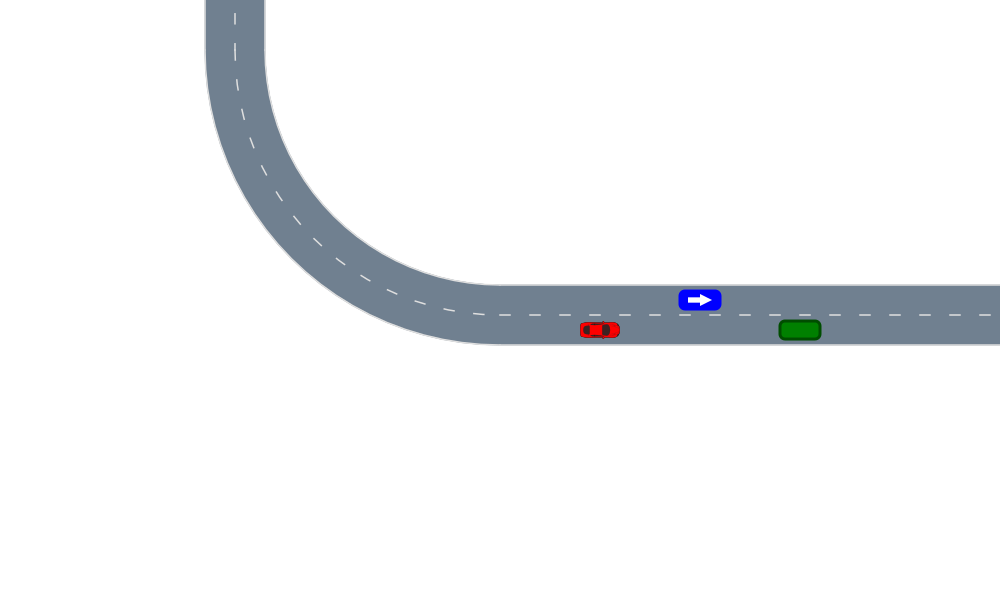

In [7]:
render([roadway, FancyCar(veh1, colorant"red"), ArrowCar(veh2, colorant"blue"), EntityRectangle(veh3, colorant"green")], 
        camera=StaticCamera(position=(0,0.), zoom=10.))

The other cameras adapts their position depending on the the scene. 

The function `update_camera!(::Camera, ::Frame)` can be called to update the position of a camera.


**Target Follow Camera**: pass in the ID of a vehicle and a zoom level, the camera will automatically center the canvas on the vehicle.

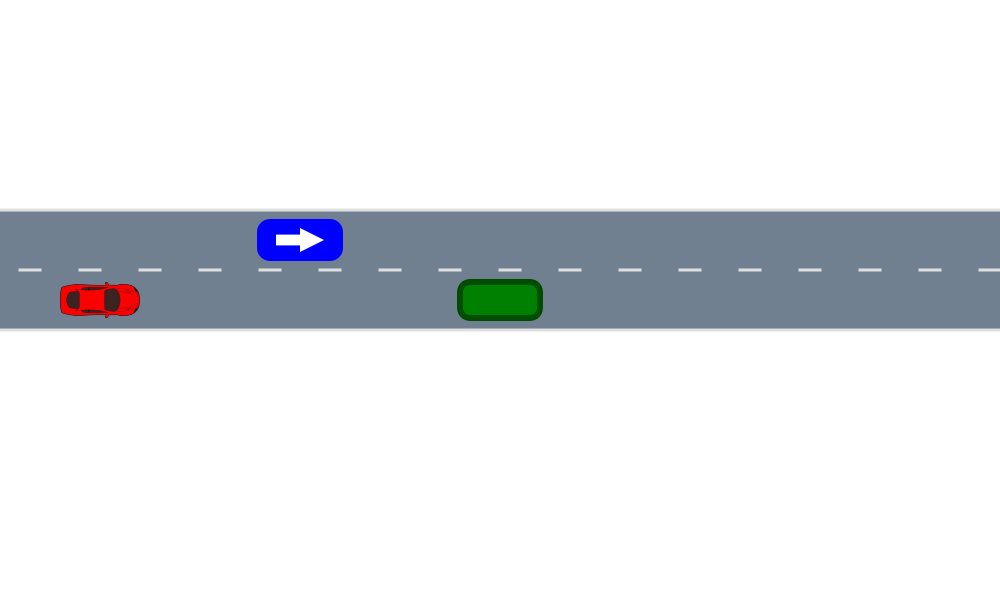

In [8]:
# the camera is centered on the green car (id=3)
cam = TargetFollowCamera(3, zoom=20.)
update_camera!(cam, scene)
render([roadway, FancyCar(veh1, colorant"red"), ArrowCar(veh2, colorant"blue"), EntityRectangle(veh3, colorant"green")], 
        camera=cam)

**Scene Follow Camera:** the camera is centered over all the vehicle present in the scene when `update_camera!` is called. Check the documentation for more details on the constructor options.

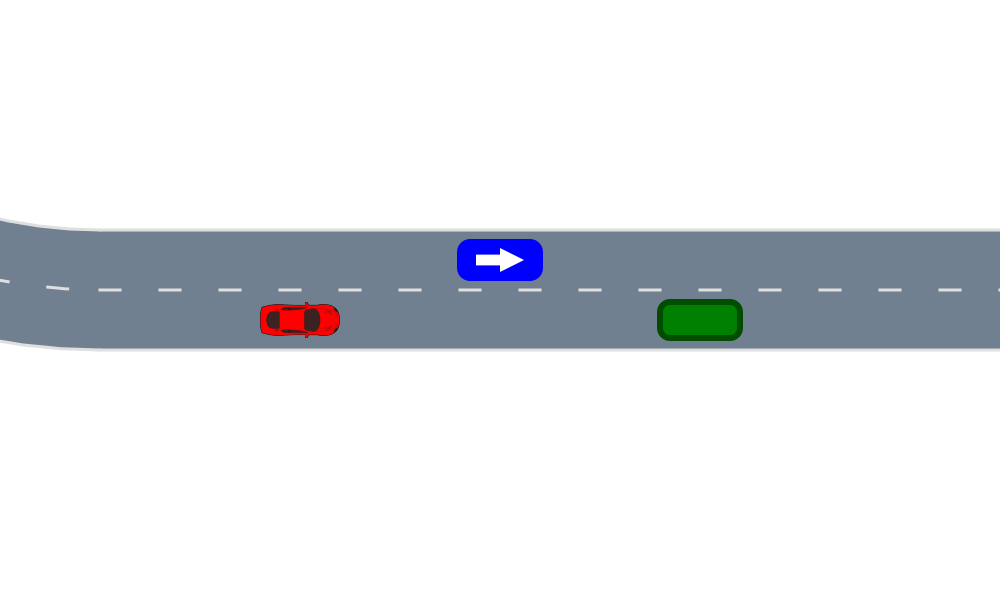

In [9]:
cam = SceneFollowCamera(zoom=20.)
update_camera!(cam, scene)
render([roadway, FancyCar(veh1, colorant"red"), ArrowCar(veh2, colorant"blue"), EntityRectangle(veh3, colorant"green")], 
        camera=cam)

AutoViz.jl also provides `ZoomingCamera` and `ComposedCamera`, check the documentation to learn more about these. 

## Overlays

Renderable objects passed to the `render` function are rendered in the order you passed them in, that is if we pass `roadway` and then `scene`, the roadway is rendered first, and the scene is rendered on top of the roadway. 
This behavior leaves the possibility to create overlays. Overlays are renderable objects that usually add some information on top of what is already rendered. 
The most basic usage is to display text, or the ID of each vehicle. 

By changing the order of the vector of renderable you can also create "underlays", like highlighting a lane below a vehicle. 

**Text Overlay**: displays some text at the desired location. The position is passed as a `VecE2` object. A coordinate system can also be specified. Look at the documentation for more information about [coordinate systems](). The text to display is passed as a list of strings which will be rendered as different lines.

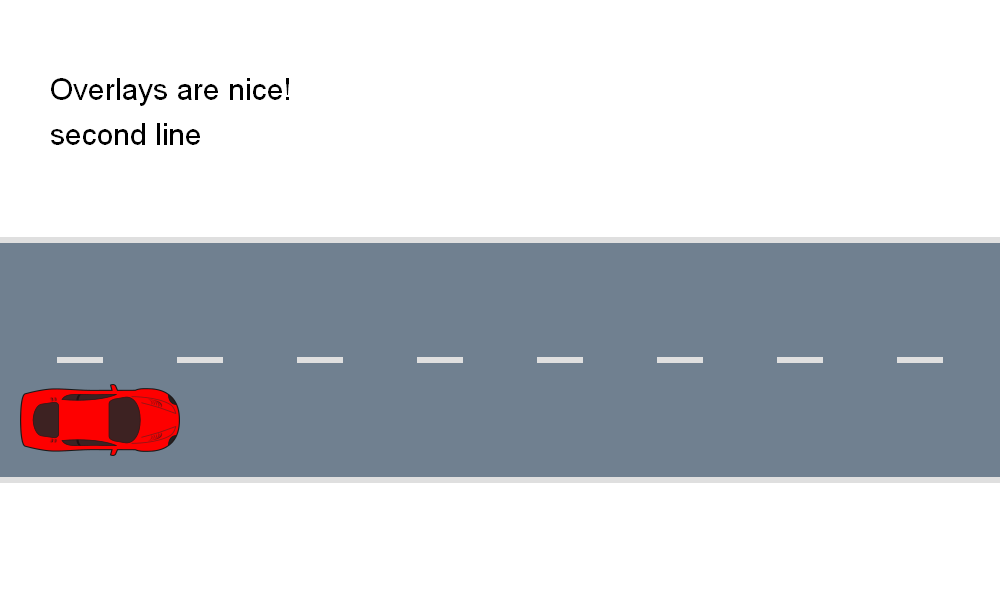

In [10]:
text_overlay = TextOverlay(text=["Overlays are nice!", "second line"], font_size=30, pos = VecE2(50.0, 100.0), color=colorant"black")
render([roadway, FancyCar(veh1, colorant"red"), text_overlay], camera=StaticCamera(position=(20,0), zoom=40.))

**ID Overlay**: displays the id of an entity on top of it. Because it needs information about the scene (to get all the IDs and position), it must be wrap into a renderable overlay.

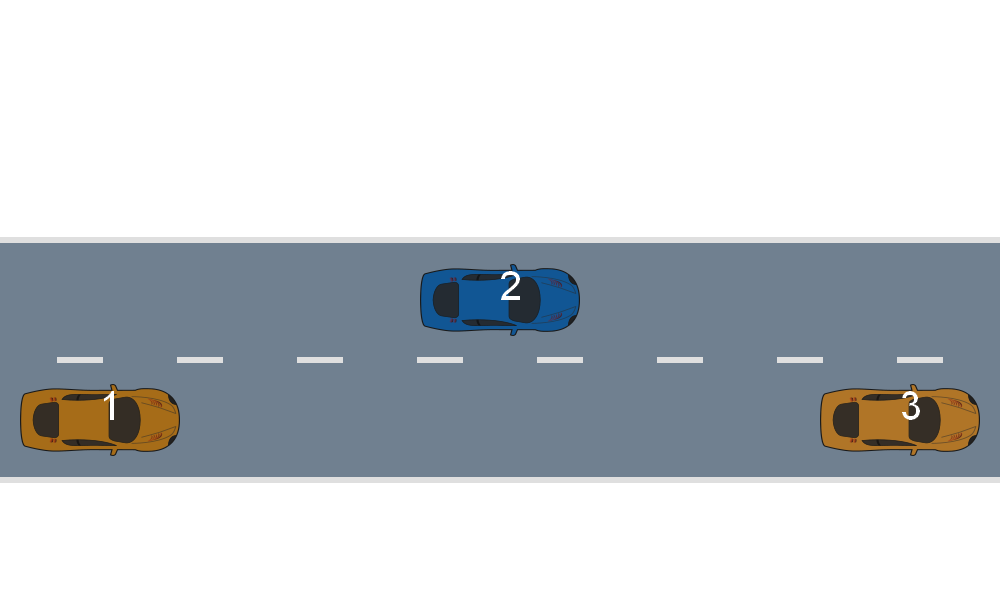

In [11]:
idoverlay = RenderableOverlay(IDOverlay(font_size=40), scene, roadway)
render([roadway, scene, idoverlay], camera=StaticCamera(position=(20,0), zoom=40.))

**Histogram overlay**: Display a bar at the specified position pos, the bar is of size width, height and is filled up to a given proportion of its height. The fill proportion is set using val, it should be a number between 0 and 1. If it is 0, the bar is not filled, if it is 1 it is filled to the top. 

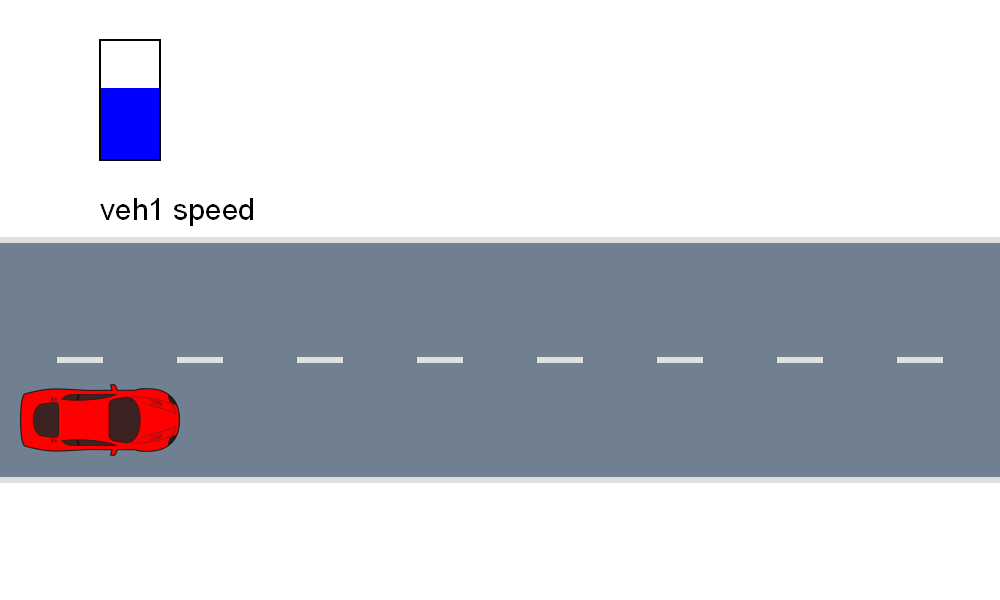

In [12]:
max_speed = 14.0
histogram_overlay = HistogramOverlay(pos = VecE2(10.0, 3.5), val=0.6, label="veh1 speed", line_color=colorant"black", 
                                   font_size=30, width=1.5, height=3.)
render([roadway, FancyCar(veh1, colorant"red"), histogram_overlay], camera=StaticCamera(position=(20,0), zoom=40.))

**Neighboars overlay**: draws a line between a vehicle and its neighbors. This overlay also needs to be wrapped as a `RenderableOverlay` which needs a scene and a roadway to perform the calculation of the neighbors.

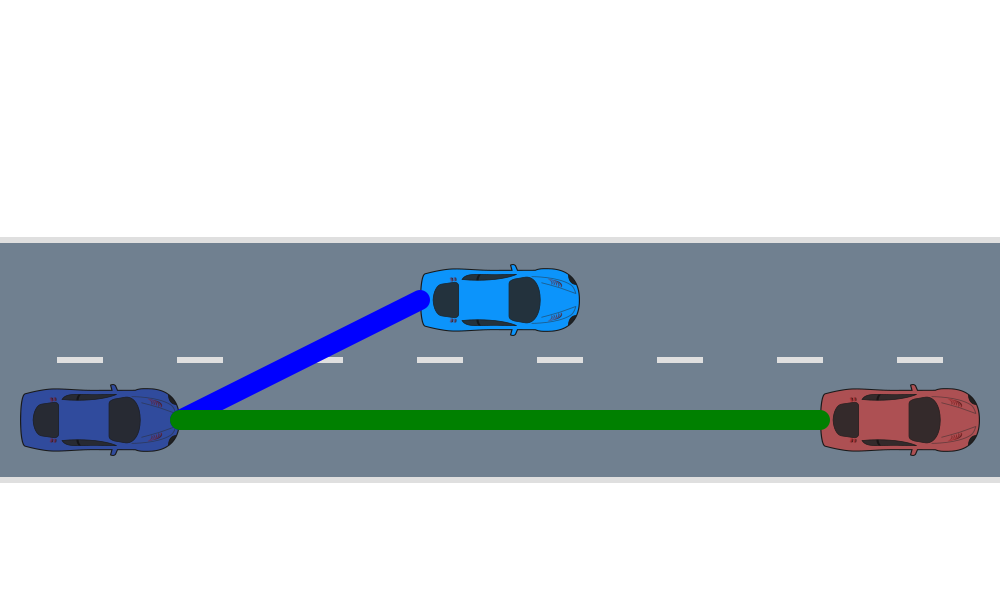

In [13]:
neighbors_overlay = RenderableOverlay(NeighborsOverlay(target_id=1), scene, roadway)
render([roadway, scene, neighbors_overlay], camera=StaticCamera(position=(20,0), zoom=40.))

**Car following stats overlay**: Diplays info about the front neighbor of a car such as the difference in velocity and the relative distance.

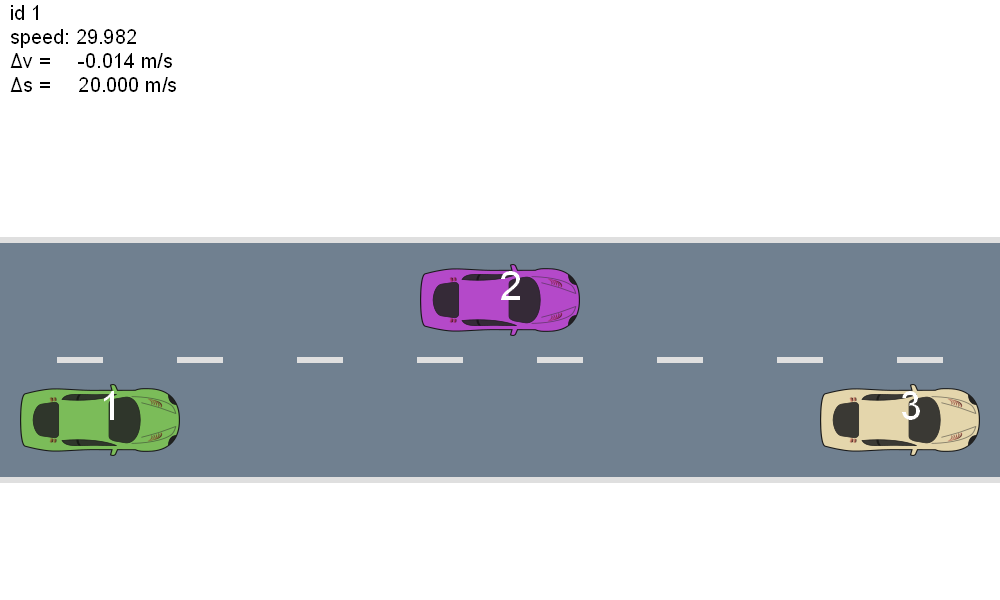

In [14]:
follow_overlay = RenderableOverlay(CarFollowingStatsOverlay(target_id=1, font_size=20, color=colorant"black"), scene, roadway)
render([roadway, scene, follow_overlay, idoverlay], camera=StaticCamera(position=(20,0), zoom=40.))

### Implementing your own overlay

Overlays are renderable object, to implement your own overlay, you need to implement a custom overlay type and the function `add_renderable!(::RenderModel, ::YourOverlay)`. 

See the section on creating your own renderables for more information.

## Animations

You can use [Reel.jl](https://github.com/shashi/Reel.jl) to generate videos.

Let's create a list of scenes first (typically you would retrieve them from a simulation or a dataset).


In [15]:
scenes = [Frame([veh1, veh2, veh3]), Frame([veh3, veh1, veh2]), Frame([veh2, veh3, veh1])];

In [16]:
using Reel
frames = Frames(MIME("image/png"), fps=2)
for i=1:3
   scene = scenes[i]
   vehicles_style = [FancyCar(scene[1], colorant"red"), ArrowCar(scene[2], colorant"blue"), EntityRectangle(scene[3], colorant"green")]
   push!(frames, render([roadway, vehicles_style... , idoverlay], camera=StaticCamera(position=(20,0), zoom=40.)))
end
frames

ArgumentError: ArgumentError: Package Reel not found in current path:
- Run `import Pkg; Pkg.add("Reel")` to install the Reel package.


## Creating your own renderables

A renderable is a custom type with associated rendering instructions. 
The instructions are passed to the render model by the `add_renderable!` function. The file `src/render_instructions.jl` contains a lot of primites that can be used to create nice renderable objects.

For example you could implement a lane rendering that would highlight a certain lane. Your object would need to contain information about the lane being highlighted and the color. Fortunately, lane objects are already renderable so this function is easy to implement!

In [17]:
# highlight the given lane with the given color
struct LaneOverlay
        lane::Lane
        color::Colorant
        roadway::Roadway
end

function AutoViz.add_renderable!(rm::RenderModel, o::LaneOverlay)
    add_renderable!(rm, o.lane, o.roadway, color_asphalt=o.color)
end

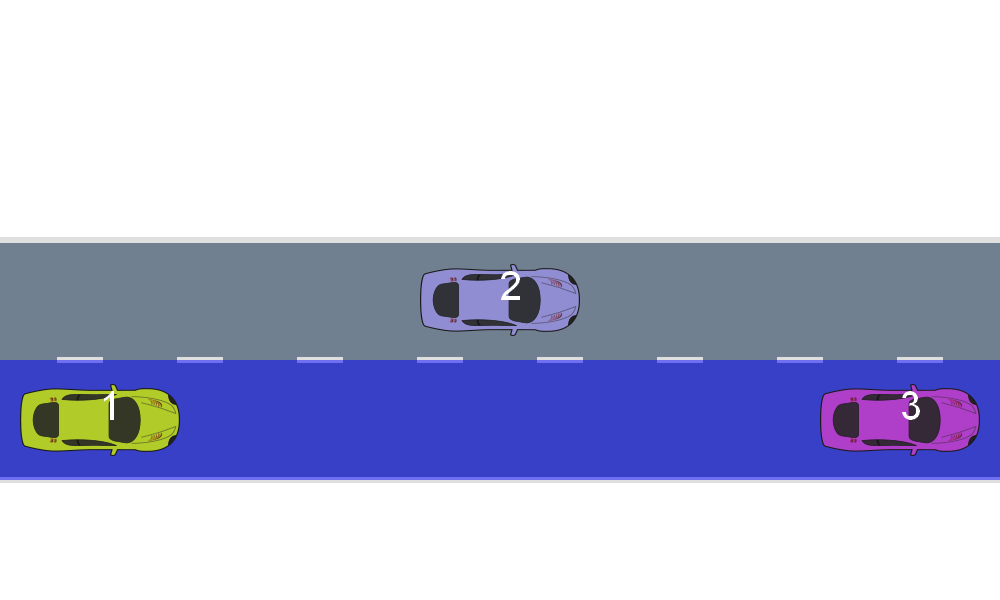

In [18]:
laneoverlay = LaneOverlay(get_lane(roadway, veh1), RGBA(0.0, 0.0, 1.0, 0.5), roadway) # highlights lane of vehicle 1 in transparent blue
render([roadway, laneoverlay, scene, idoverlay], camera=StaticCamera(position=(20,0), zoom=40.))

Note that here we passed the `laneoverlay` object before the scene so that the highlighting is displayed on top of the roadway but below the vehicles.